In [52]:
import functools as ft
import os

import equinox as eqx
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from ipywidgets import interact
from jax import config, device_count, random
from scipy import constants
from tqdm import tqdm

from ising.state import Environment, State
from ising.types import Algorithm
from ising.utils.random import EasyKey
from ising.primitives.utils import beta_to_temp

# CPU cores as separate devices
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

config.update("jax_platform_name", "cpu")
config.update("jax_platforms", "cpu")
# config.update("jax_enable_x64", True)
# config.update("jax_check_tracer_leaks", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

%load_ext autoreload
%autoreload 2

if "profiler_is_running" not in globals():
    profiler_is_running = False

    import jax.profiler

    jax.profiler.start_server(9999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Init
k = EasyKey(np.random.randint(0, 10**10))
rng_key = random.PRNGKey(np.random.randint(0, 10**10))

spin = 0.5
# spin = 1.0
dimensions = 2
size = 64

ENVIRONMENT_BASE_PARAMS = {
    # Beta
    "interaction_bilinear": 1.0,
    "interaction_biquadratic": 0.0,
    "interaction_anisotropy": 0.0,
    "interaction_bicubic": 0.0,
    "interaction_external_field": 0.0,
    "nuclear_magnetic_moment": 1.0,
    "algorithm": Algorithm.WOLFF,
    "probabilistic_cluster_accept": False,
}

BETA_MIN = 0.5
BETA_MAX = 2.5
# BETA_COUNT = 2 ** 5
BETA_COUNT = device_count()
# betas = np.geomspace(0.25, 5, 2**5)
betas = np.geomspace(BETA_MIN, BETA_MAX, BETA_COUNT)

# n_device_samples = device_count()
n_device_samples = 1
n_subsamples = 8
# 5 120 000
# 50 00 000
stepsize_sweeps = 50
n_steps = 50

In [54]:
# Single state

env = Environment.from_spin(spin=spin, beta=1.0, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=dimensions, size=size, env=env, id_=0
)

# state = state.evolve_steps(1000, rng_key=k.new)
initial_state = state
state = state.evolve_sweeps(1, rng_key=k.new)
# measured = state.measure(rng_key=k.new, num=1, sweeps=10)

state.calculate_energy()
state.calculate_magnetisation_density()

Array(-0.00561523, dtype=float32)

In [55]:
def transforms(in_axes, out_axes):
    def inner(fun):
        fun = eqx.filter_jit(fun)
        fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


@transforms(in_axes=(0, None, None, None, 0, 0, None), out_axes=0)
def make_states(rng_key, spin, dimensions, size, beta, id_, kwargs):
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, k = random.split(rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    )
    # state = State.uniform_random_square_from_env(
    #     rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    # )

    return state


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_states(sweeps, key, state):
    return state.evolve_sweeps(sweeps, key)


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_and_measure_states(sweeps, key, state):
    evolve_key, measure_key = random.split(key)
    state = state.evolve_sweeps(sweeps, evolve_key)
    measurement = state.measure(rng_key=measure_key, num=1, sweeps=0)

    return state, measurement

In [56]:
shape = (n_device_samples, n_subsamples, *betas.shape)
state_keys = k.shaped(shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=n_device_samples,
    subsamples=n_subsamples,
)


states = make_states(
    state_keys, spin, dimensions, size, _betas, ids, ENVIRONMENT_BASE_PARAMS
)

evolve_measurements = []
for i in tqdm(range(n_steps)):
    keys = k.shaped(shape)
    states, measurement = evolve_and_measure_states(stepsize_sweeps, keys, states)
    evolve_measurements.append(measurement)

100%|██████████| 50/50 [03:27<00:00,  4.16s/it]


In [57]:
states_list = states.unensamble()

In [58]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
measurements = {key: [] for key in measurement_keys}
for step_m in evolve_measurements:
    for key in measurement_keys:
        data = getattr(step_m, key).flatten().tolist()
        measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


df = pd.DataFrame(measurements)
df["beta"] = df["state_id"].apply(id_to_beta)
df["temperature"] = 1.0 / df["beta"]
df["abs_magnetisation_density"] = np.abs(df["magnetisation_density"])

In [59]:
df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,abs_magnetisation_density
0,787,50,0,-3220.0,-0.310303,0.500000,2.000000,0.310303
1,1348,50,1,-2818.0,-0.197266,0.508543,1.966402,0.197266
2,1172,50,2,-2950.0,-0.233398,0.517232,1.933369,0.233398
3,1094,50,3,-2952.0,-0.257324,0.526069,1.900891,0.257324
4,1641,50,4,-2570.0,-0.131592,0.535057,1.868959,0.131592
...,...,...,...,...,...,...,...,...
38395,10238026,2500,763,-4096.0,-0.500000,2.336198,0.428046,0.500000
38396,10230234,2500,764,-4096.0,-0.500000,2.376114,0.420855,0.500000
38397,10238630,2500,765,-4096.0,-0.500000,2.416712,0.413785,0.500000
38398,10238823,2500,766,-4092.0,-0.499756,2.458003,0.406834,0.499756


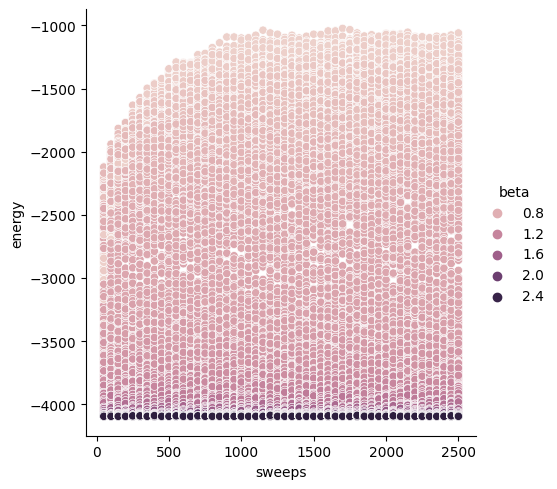

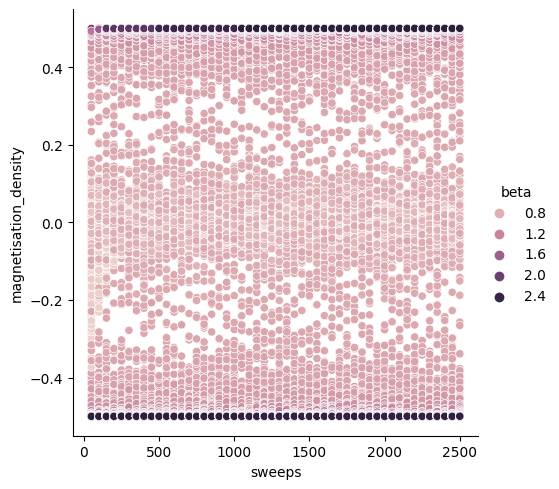

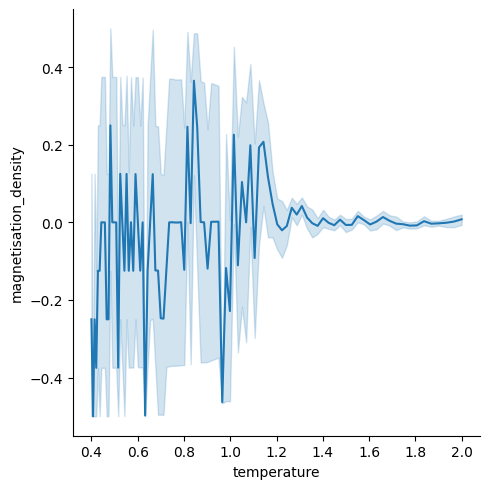

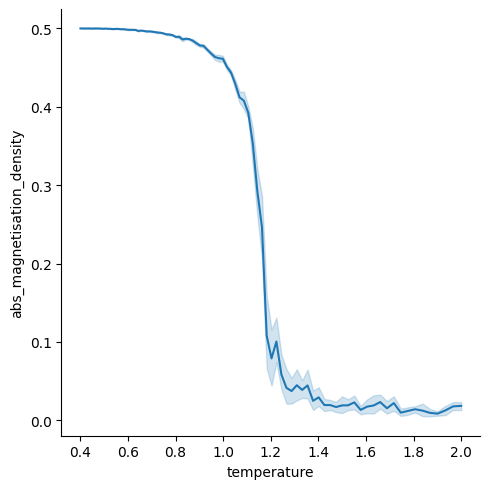

In [60]:
sns.relplot(data=df, x="sweeps", y="energy", hue="beta")
sns.relplot(
    data=df,
    x="sweeps",
    y="magnetisation_density",
    hue="beta",
)
sns.relplot(
    data=df[df["sweeps"] == np.max(df["sweeps"])],
    x="temperature",
    y="magnetisation_density",
    # hue="beta",
    kind="line",
    # errorbar=None
)
sns.relplot(
    data=df[df["sweeps"] == np.max(df["sweeps"])],
    x="temperature",
    y="abs_magnetisation_density",
    # hue="beta",
    kind="line",
    # errorbar=None
)

In [61]:
df[df["steps"] == np.max(df["steps"])]

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,abs_magnetisation_density
37727,10239118,2500,95,-4096.0,-0.5,2.5,0.4,0.5


In [62]:
temp_states = states_list[:BETA_COUNT]


@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.dpi = 500

interactive(children=(IntSlider(value=47, description='i', max=95), Output()), _dom_classes=('widget-interact'…

In [63]:
@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)


keys = k.shaped(states.vectorisation_shape)
equil_measurements = measure_states(keys, states, 32, 30)

In [64]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
eq_measurements = {key: [] for key in measurement_keys}
for key in measurement_keys:
    data = getattr(equil_measurements, key).flatten().tolist()
    eq_measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


eq_measurements


eq_df = pd.DataFrame(eq_measurements)
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = 1.0 / eq_df["beta"]
eq_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature
0,12236,2530,0,-1120.0,0.019531,0.5,2.0
1,12264,2530,0,-1128.0,0.004395,0.5,2.0
2,12239,2530,0,-1106.0,0.017822,0.5,2.0
3,12244,2530,0,-1140.0,0.007324,0.5,2.0
4,12227,2530,0,-1104.0,0.005127,0.5,2.0
...,...,...,...,...,...,...,...
24571,10357760,2530,767,-4096.0,0.500000,2.5,0.4
24572,10357758,2530,767,-4096.0,0.500000,2.5,0.4
24573,10357756,2530,767,-4096.0,0.500000,2.5,0.4
24574,10357750,2530,767,-4096.0,0.500000,2.5,0.4


In [65]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states


sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()


# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df["state_id"] = sum_df.index

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = 1.0 / sum_df["beta"]

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(
    np.gradient(sum_df["energies_mean"], sum_df["temperature"])
)
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(
    np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"])
)
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()


# mag_2_mean = np.mean(mag_2)
# mag_4_mean = np.mean(mag_4)

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (
    3.0 * np.square(sum_df["mag_2_mean"])
)

In [66]:
sum_df

,energies_mean,energies_var,mag_dens_mean,mag_dens_var,state_id,beta,temperature,natural_temperature,heat_cap_gradient,heat_cap_fluctuation,mag_sus_gradient,mag_sus_fluctuation,mag_1_mean,mag_2_mean,mag_4_mean,binder_2,binder_4
state_id,,,,,,,,,,,,,,,,,
0,-1129.2500,522.774194,0.004044,7.048321e-05,0,0.500000,1.448594e+23,2.000000,1.602656e-20,1.804419e-21,2.865577e-24,2.432814e-28,0.007202,0.000085,2.215447e-08,-6.315714e-01,-6.977166e-01
1,-1168.2500,487.677419,0.011017,5.443538e-05,1,0.508543,1.424260e+23,1.966402,1.159400e-20,1.741290e-21,2.052553e-24,1.943658e-28,0.011383,0.000174,5.520572e-08,-3.436739e-01,-2.737377e-01
2,-1185.5625,573.608871,0.014015,8.940643e-05,2,0.517232,1.400334e+23,1.933369,8.075283e-21,2.118700e-21,1.506336e-24,3.302345e-28,0.014961,0.000283,1.479872e-07,-2.644737e-01,-2.824282e-01
3,-1206.5000,446.193548,0.004089,6.132357e-05,3,0.526069,1.376810e+23,1.900891,1.933291e-20,1.704873e-21,8.202888e-24,2.343129e-28,0.007111,0.000076,1.606489e-08,-5.057194e-01,-5.906080e-01
4,-1274.9375,363.608871,-0.023941,9.392899e-05,4,0.535057,1.353681e+23,1.868959,4.368937e-20,1.437204e-21,3.694128e-24,3.712646e-28,0.023941,0.000664,6.526925e-07,-1.587542e-01,-1.598775e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-4094.0000,7.225806,-0.499878,2.691823e-08,763,2.336198,3.100323e+22,0.428046,6.172099e-22,5.444889e-22,8.772603e-22,2.028379e-30,0.499878,0.249878,6.243903e-02,-1.043591e-07,-1.391017e-07
764,-4095.0000,3.096774,-0.499939,1.153638e-08,764,2.376114,3.048242e+22,0.420855,8.288222e-22,2.413945e-22,3.070619e-23,8.992645e-31,0.499939,0.249939,6.246950e-02,-4.471440e-08,-5.960464e-08
765,-4094.8750,3.338710,-0.468697,3.123082e-02,765,2.416712,2.997035e+22,0.413785,1.210196e-22,2.692227e-22,1.035287e-24,2.518352e-24,0.499931,0.249931,6.246569e-02,-4.820918e-08,-6.426517e-08


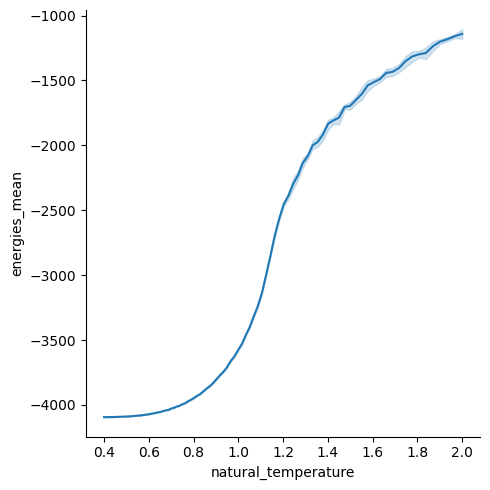

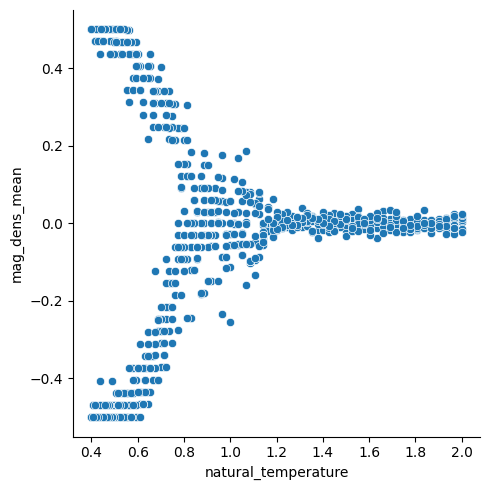

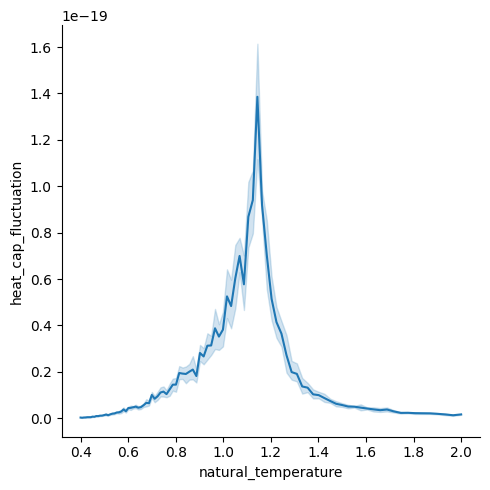

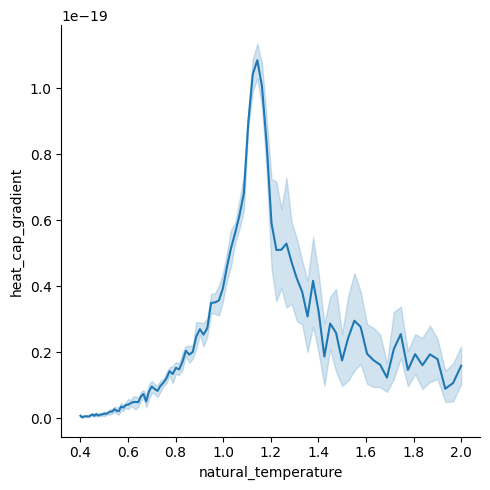

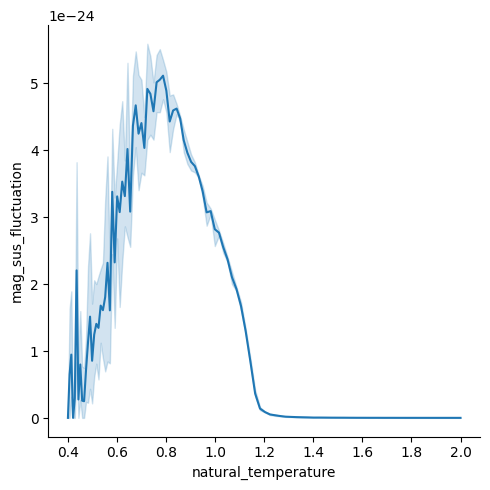

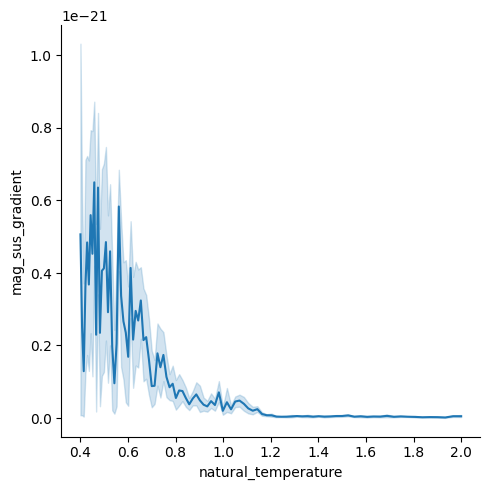

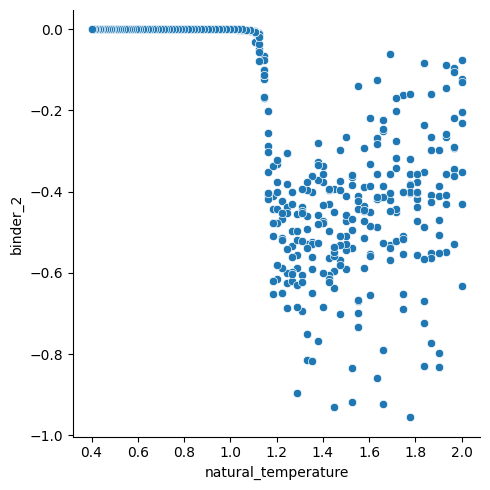

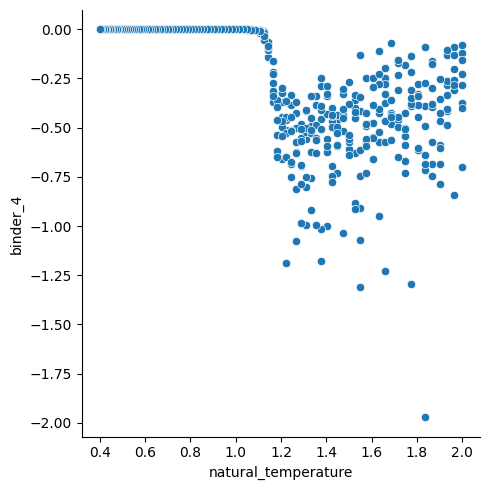

In [69]:
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="energies_mean",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_dens_mean",
    # kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    # kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    # kind="line",
)

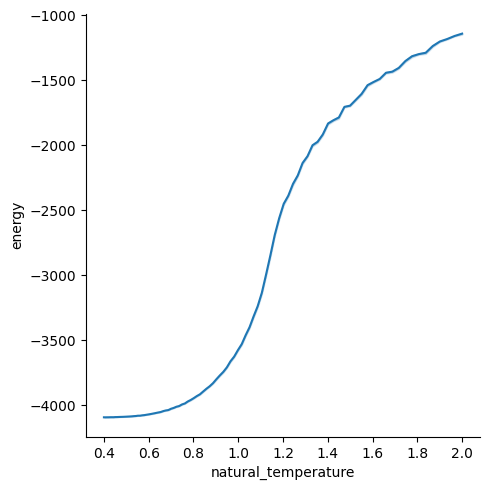

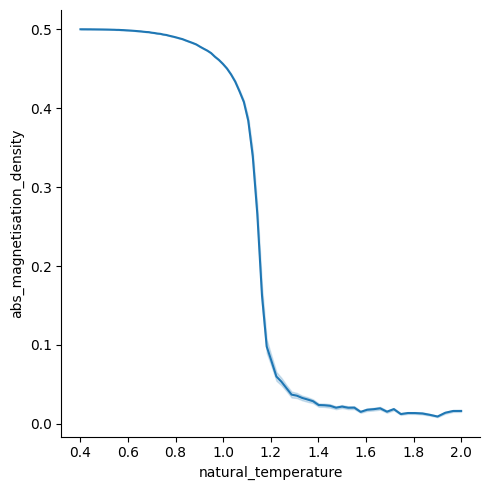

In [68]:
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)